In [33]:
import pandas as pd

# Load the dataset
file_path = "../data/FE_no_outliers_dataset.csv"
df_cleaned = pd.read_csv(file_path)

In [34]:
df_cleaned.columns

Index(['contract-delivery', 'demand-forecast', 'temperature-normal',
       'temperature-forecast', 'solar-forecast', 'day-ahead-auction-price',
       'wind-forecast', 'day-ahead-auction-time', 'hour', 'day_of_week',
       'month', 'is_weekend', 'quarter', 'year', 'dayofyear', 'dayofmonth',
       'weekofyear', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_std_7', 'wind_volatility',
       'solar_volatility', 'price_volatility', 'wind_solar_interaction',
       'demand_to_renewable_ratio', 'lag_2', 'lag_3', 'lag_14', 'lag_21'],
      dtype='object')

# Train XGBoost

In [35]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define features and target variable
features = [
    "demand-forecast", "solar-forecast", "wind-forecast", "temperature-forecast", 
    "hour", "day_of_week", "month", "lag_1", "rolling_mean_7", "rolling_std_7", 
    "renewable_ratio", "hour_sin", "hour_cos"
]
features = ['demand-forecast', 'temperature-normal',
       'temperature-forecast', 'solar-forecast',
       'wind-forecast', 'hour', 'day_of_week',
       'month', 'is_weekend', 'hour_sin', 'hour_cos', 'day_of_week_sin',
       'day_of_week_cos', 'month_sin', 'month_cos', 'lag_1', 'lag_7',
       'rolling_mean_7', 'rolling_std_7', 'wind_volatility',
       'solar_volatility', 'wind_solar_interaction',
       'demand_to_renewable_ratio',
           'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
            'lag_2', 'lag_3', 'lag_14', 'lag_21'
           ]
target = "day-ahead-auction-price"

# Split data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df_cleaned[features], df_cleaned[target], test_size=0.2, random_state=42, shuffle=False
)

# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective="reg:squarederror",  # Regression task
    n_estimators=500,              # Number of boosting rounds
    learning_rate=0.05,            # Step size shrinkage
    max_depth=6,                   # Depth of each tree
    subsample=0.8,                 # Row sampling
    colsample_bytree=0.8,          # Feature sampling
    random_state=42
)

# Train model
xgb_model.fit(X_train, y_train)

# Predict on test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
xgb_mae = mean_absolute_error(y_test, y_pred_xgb)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb))

print(f"XGBoost Model - MAE: {xgb_mae:.2f}, RMSE: {xgb_rmse:.2f}")


XGBoost Model - MAE: 14.92, RMSE: 19.94


| Model                                            | Mae lower is better | Rmse lower is better |
| :----------------------------------------------- | :------------------ | :------------------- |
| Historical Average                               | 30.37               | 40.85                |
| Initial Linear Regression                        | 17.7                | 23.81                |
| Improved Linear Regression (Feature Engineering) | 16.24               | 21.42                |
| XGBoost (Default Settings)                       | 15.12               | 20.06                |
| Tuned XGBoost (Hyperparameter Search)            | **14.86**           | **19.73**            |

# Feature Importance

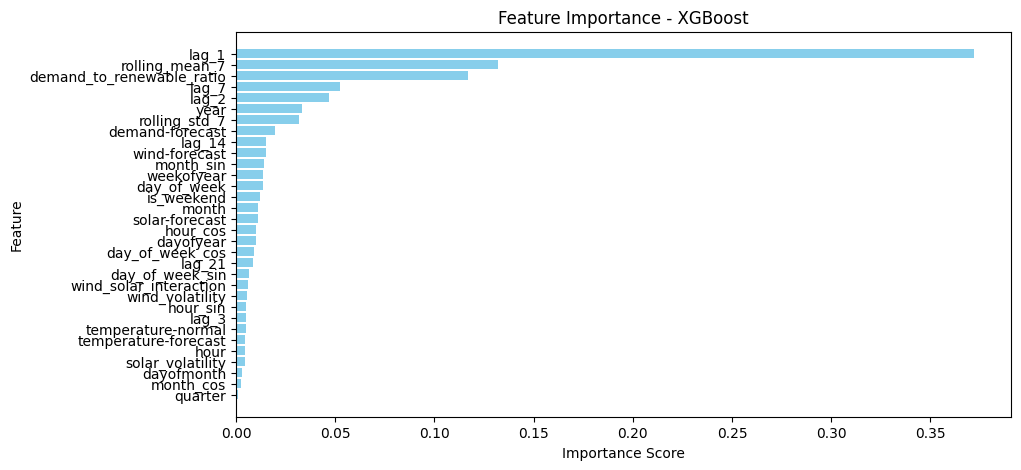

In [36]:
import matplotlib.pyplot as plt
import xgboost as xgb

# Get feature importance
importance = xgb_model.feature_importances_

# Create DataFrame for visualization
feature_importance_df = (
    pd.DataFrame({"Feature": features, "Importance": importance})
    .sort_values(by="Importance", ascending=False)
)

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color="skyblue")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Feature Importance - XGBoost")
plt.gca().invert_yaxis()
plt.show()


# XGBoost Hyperparameter Tuning with GridSearchCV

In [6]:
from sklearn.model_selection import GridSearchCV

# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 500, 800],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

# Initialize XGBoost model
xgb_model_tune = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)

# Run GridSearch
grid_search = GridSearchCV(
    estimator=xgb_model_tune,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,  # Time-based cross-validation could be better
    verbose=2
)

# Fit GridSearch to training data
grid_search.fit(X_train, y_train)

# Get best parameters
print("Best Parameters:", grid_search.best_params_)

# Train final model with best parameters
best_xgb = xgb.XGBRegressor(**grid_search.best_params_)
best_xgb.fit(X_train, y_train)

# Predictions
y_pred_best_xgb = best_xgb.predict(X_test)

# Evaluate tuned model
best_xgb_mae = mean_absolute_error(y_test, y_pred_best_xgb)
best_xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_best_xgb))

print(f"Tuned XGBoost - MAE: {best_xgb_mae:.2f}, RMSE: {best_xgb_rmse:.2f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.7; total time=   0.3s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.8; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=4, n_estimators=200, subsample=0.9; total time=   0.2s
[CV] END 

<strong data-start="89" data-end="121">Performance Comparison</strong></h3>
<div class="overflow-x-auto contain-inline-size"><table data-start="125" data-end="477" node="[object Object]"><thead data-start="125" data-end="183"><tr data-start="125" data-end="183"><th data-start="125" data-end="133">Model</th><th data-start="133" data-end="157">MAE (Lower is Better)</th><th data-start="157" data-end="183">RMSE (Lower is Better)</th></tr></thead><tbody data-start="209" data-end="477"><tr data-start="209" data-end="251"><td><strong data-start="211" data-end="233">Historical Average</strong></td><td>30.37</td><td>40.85</td></tr><tr data-start="252" data-end="301"><td><strong data-start="254" data-end="283">Initial Linear Regression</strong></td><td>17.70</td><td>23.81</td></tr><tr data-start="302" data-end="374"><td><strong data-start="304" data-end="356">Improved Linear Regression (Feature Engineering)</strong></td><td>16.24</td><td>21.42</td></tr><tr data-start="375" data-end="425"><td><strong data-start="377" data-end="407">XGBoost (Default Settings)</strong></td><td>15.12</td><td>20.06</td></tr><tr data-start="426" data-end="477"><td><strong data-start="428" data-end="445">Tuned XGBoost</strong></td><td><strong data-start="448" data-end="457">14.86</strong> 🔽</td><td><strong data-start="463" data-end="472">19.73</strong> 🔽</td></tr></tbody></table></div>


In [37]:
import pickle
file_name = "best_xgb.pkl"

# save
pickle.dump(best_xgb, open(file_name, "wb"))

# load
#xgb_model_loaded = pickle.load(open(file_name, "rb"))

# Ensemble Models (Stacking XGBoost + LightGBM)

In [13]:
import lightgbm as lgb
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge

# Define base models
xgb_model = xgb.XGBRegressor(**grid_search.best_params_)
lgb_model = lgb.LGBMRegressor(n_estimators=500, learning_rate=0.05, max_depth=4, random_state=42)

# Define stacking model (XGBoost + LightGBM + Ridge)
stacking_model = StackingRegressor(
    estimators=[("xgb", xgb_model), ("lgb", lgb_model)],
    final_estimator=Ridge(alpha=1.0)  # Simple linear model to blend predictions
)

# Train stacking model
stacking_model.fit(X_train, y_train)

# Predict & evaluate
y_pred_stack = stacking_model.predict(X_test)
stack_mae = mean_absolute_error(y_test, y_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacked Model - MAE: {stack_mae:.2f}, RMSE: {stack_rmse:.2f}")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000645 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 33164, number of used features: 13
[LightGBM] [Info] Start training from score 85.048499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Stacked Model (XGBoost + LightGBM + Ridge) - MAE: 15.33, RMSE: 20.39

| Model                                            | Mae lower is better | Rmse lower is better |
| :----------------------------------------------- | :------------------ | :------------------- |
| Historical Average                               | 30.37               | 40.85                |
| Initial Linear Regression                        | 17.7                | 23.81                |
| Improved Linear Regression (Feature Engineering) | 16.24               | 21.42                |
| XGBoost (Default Settings)                       | 15.12               | 20.06                |
| Tuned XGBoost (Hyperparameter Search)            | **14.86**           | **19.73**            |
| Stacked Model (XGBoost + LightGBM + Ridge)       | 15.33               | 20.39                |

This is slightly worse than tuned XGBoost (MAE: 14.86, RMSE: 19.73) but still competitive.

Why didn't stacking improve performance much?
- XGBoost & LightGBM are similar gradient boosting models—so stacking them doesn't add much diversity.
- The linear Ridge model might not optimally blend predictions.

# Hyperparameter Tune LightGBM for Better Stacking

In [ ]:
lgb_param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [4, 6, 8],
    "n_estimators": [200, 500, 800],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.7, 0.8, 0.9]
}

lgb_model_tune = lgb.LGBMRegressor()
grid_search_lgb = GridSearchCV(lgb_model_tune, lgb_param_grid, cv=3, scoring="neg_mean_absolute_error", verbose=2)
grid_search_lgb.fit(X_train, y_train)

print("Best LightGBM Parameters:", grid_search_lgb.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001447 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 22109, number of used features: 13
[LightGBM] [Info] Start training from score 109.903808
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

In [21]:
# lightGBM prediction
# Predict & evaluate
y_pred_lgbm = grid_search_lgb.predict(X_test)
stack_mae = mean_absolute_error(y_test, y_pred_lgbm)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm))

print(f"LGBM - MAE: {stack_mae:.2f}, RMSE: {stack_rmse:.2f}")

LGBM - MAE: 15.93, RMSE: 20.81


| Model                                            | Mae lower is better | Rmse lower is better |
| :----------------------------------------------- | :------------------ | :------------------- |
| Historical Average                               | 30.37               | 40.85                |
| Initial Linear Regression                        | 17.7                | 23.81                |
| Improved Linear Regression (Feature Engineering) | 16.24               | 21.42                |
| XGBoost (Default Settings)                       | 15.12               | 20.06                |
| Tuned XGBoost (Hyperparameter Search)            | **14.86**           | **19.73**            |
| Stacked Model (XGBoost + LightGBM + Ridge)       | 15.33               | 20.39                |
| lightGBM (tuned)                                 | 15.93               | 20.81                |

In [17]:
import pickle
file_name = "best_lgbm.pkl"

# save
pickle.dump(grid_search_lgb, open(file_name, "wb"))

# load
#grid_search_lgb = pickle.load(open(file_name, "rb"))

In [19]:
# Use tuned LGBM in stacking
stacking_model = StackingRegressor(
    estimators=[("xgb", best_xgb), ("lgb", lgb.LGBMRegressor(**grid_search_lgb.best_params_))],
    final_estimator=Ridge(alpha=1.0)
)
stacking_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2125
[LightGBM] [Info] Number of data points in the train set: 33164, number of used features: 13
[LightGBM] [Info] Start training from score 85.048499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

StackingRegressor(estimators=[('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.7, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rat...
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=500, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                              ('lgb',
                               LGBMRegressor(colsample_bytree=0.7,
                                             learning_rate=0.05, max_depth=4,
                                             n_estimators=800,
                                             subsample=0.7))],
                  final_estimator=Ridge())

In [20]:
# Predict & evaluate
y_pred_stack = stacking_model.predict(X_test)
stack_mae = mean_absolute_error(y_test, y_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacked Model with tuned LGBM - MAE: {stack_mae:.2f}, RMSE: {stack_rmse:.2f}")

Stacked Model with tuned LGBM - MAE: 15.47, RMSE: 20.41


| Model                                            | Mae lower is better | Rmse lower is better |
| :----------------------------------------------- | :------------------ | :------------------- |
| Historical Average                               | 30.37               | 40.85                |
| Initial Linear Regression                        | 17.7                | 23.81                |
| Improved Linear Regression (Feature Engineering) | 16.24               | 21.42                |
| XGBoost (Default Settings)                       | 15.12               | 20.06                |
| Tuned XGBoost (Hyperparameter Search)            | **14.86**           | **19.73**            |
| Stacked Model (XGBoost + LightGBM + Ridge)       | 15.33               | 20.39                |
| lightGBM (tuned)                                 | 15.93               | 20.81                |
| Stacked Model with tuned LGBM                    | 15.47               | 20.41                |


# Random Forest as final Regressor


In [38]:
from sklearn.ensemble import RandomForestRegressor

stacking_model = StackingRegressor(
    estimators=[("xgb", best_xgb), ("lgb", grid_search_lgb)],
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)
)
stacking_model.fit(X_train, y_train)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4793
[LightGBM] [Info] Number of data points in the train set: 21082, number of used features: 32
[LightGBM] [Info] Start training from score 112.073980
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

Exception ignored on calling ctypes callback function: <function _log_callback at 0x12e32eac0>
Traceback (most recent call last):
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x12e32eac0>
Traceback (most recent call last):
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x12e32eac0>
Traceback (most recent call last):
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x12e32eac0>
Traceback (most recent call last):
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x12e32eac0>
Traceback (most recent call last):
  File "/Users/alfonzo/Library/Application Support/pipx/venvs/jupyterlab/lib/python3.12/site-packages/lightgbm/basic.py", line 287, in _log_callback
    def _log_callback(msg: bytes) -> None:
    
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


KeyboardInterrupt



In [ ]:
# Predict & evaluate
y_pred_stack = stacking_model.predict(X_test)
stack_mae = mean_absolute_error(y_test, y_pred_stack)
stack_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stack))

print(f"Stacked Model Best XGB, best LGBM, RandomForestRegressor - MAE: {stack_mae:.2f}, RMSE: {stack_rmse:.2f}")

In [ ]:
file_name = "rft_stacking.pkl"

# save
pickle.dump(stacking_model, open(file_name, "wb"))